# Performance of cost functions

This is not really a tutorial, but more of a benchmark of the builtin cost functions.

We test the performance of the cost functions shipped with iminuit. We check that they produce unbiased results with proper variance. To do that, we generate normal distributed data many times and fit a normal distribution to each independent data set. The bias is computed from the averages of these reconstructed parameters. We also compute the mean of the estimated variance for each data set, which should converge to 1.

Since we do the fit many times, we do not use implementations of the pdf and cdf of a normal distribution from `scipy.stats`, but Numba-accelerated versions from the `numba-stats` package. For the binned fits, we compute histograms of the data with $3 + n/10$ equidistant bins, where $n$ is the sample size.

Disclaimer: This tutorial is targeted at experts, please read the code to understand what is going on.

## Maximum-likelihood fits

Here we check that the different maximum-likelihood cost functions produce asymptotically unbiased results with the expected variance.

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from iminuit import Minuit
from iminuit.cost import (
    UnbinnedNLL,
    BinnedNLL,
    ExtendedUnbinnedNLL,
    ExtendedBinnedNLL,
    LeastSquares,
)
from argparse import Namespace
import numba as nb
import math
from numba_stats import norm
import joblib

In [15]:
n_tries = 100  # increase this to get less scattering

n_pts = np.array((10, 30, 100, 300, 1000, 3000, 10000))

truth = Namespace(mu=0, sigma=1)


# function that runs random experiments with sample size n
@joblib.delayed
def compute(n):
    rng = np.random.default_rng(n)
    np.random.seed(n)
    u_nll = []
    b_nll = []
    e_u_nll = []
    e_b_nll = []
    for i_try in range(n_tries):
        while True:
            k = 2 * rng.poisson(n)
            x = rng.normal(truth.mu, truth.sigma, size=k)
            x = x[np.abs(x) < 2]
            x = x[:k]
            xrange = np.array((-2.0, 2.0))
            nh, xe = np.histogram(x, bins=3 + n // 10, range=xrange)
            m = [
                # model must be a normalized pdf
                Minuit(
                    UnbinnedNLL(
                        x,
                        lambda x, mu, sigma: (
                            norm.pdf(x, mu, sigma) / np.diff(norm.cdf(xrange, mu, sigma))
                        ),
                    ),
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a function that returns the integral over the scaled pdf and the scaled pdf
                Minuit(
                    ExtendedUnbinnedNLL(
                        x,
                        lambda x, n, mu, sigma: (
                            n * np.diff(norm.cdf(xrange, mu, sigma)),
                            n * norm.pdf(x, mu, sigma),
                        ),
                    ),
                    n=n,
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a normalized cdf up to an arbitrary additive constant (only differences are used)
                Minuit(
                    BinnedNLL(
                        nh,
                        xe,
                        lambda x, mu, sigma: (
                            norm.cdf(x, mu, sigma) / np.diff(norm.cdf(xrange, mu, sigma))
                        ),
                    ),
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a scaled cdf up to an arbitrary additive constant (only differences are used)
                Minuit(
                    ExtendedBinnedNLL(
                        nh, xe, lambda x, n, mu, sigma: n * norm.cdf(x, mu, sigma)
                    ),
                    n=n,
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
            ]
            for mi in m:
                mi.limits["sigma"] = (1e-3, None)
                if "n" in mi.parameters:
                    mi.limits["n"] = (0, None)

            # only accept a random data set when all fits converged ok
            all_good = True
            for mi in m:
                mi.migrad()
                mi.hesse()
                if not mi.valid or not mi.accurate:
                    all_good = False
                    break
            if all_good:
                break
            print(f"{n} {i_try} need to re-try {[(mi.valid, mi.accurate) for mi in m]}")

        # store parameter deviations and estimated variances for each pseudo-experiment
        u_nll.append(
            (
                m[0].values["mu"] - truth.mu,
                m[0].errors["mu"] ** 2,
                m[0].values["sigma"] - truth.sigma,
                m[0].errors["sigma"] ** 2,
            )
        )
        e_u_nll.append(
            (
                m[1].values["n"] - n,
                m[1].errors["n"] ** 2,
                m[1].values["mu"] - truth.mu,
                m[1].errors["mu"] ** 2,
                m[1].values["sigma"] - truth.sigma,
                m[1].errors["sigma"] ** 2,
            )
        )
        b_nll.append(
            (
                m[2].values["mu"] - truth.mu,
                m[2].errors["mu"] ** 2,
                m[2].values["sigma"] - truth.sigma,
                m[2].errors["sigma"] ** 2,
            )
        )
        e_b_nll.append(
            (
                m[3].values["n"] - n,
                m[3].errors["n"] ** 2,
                m[3].values["mu"] - truth.mu,
                m[3].errors["mu"] ** 2,
                m[3].values["sigma"] - truth.sigma,
                m[3].errors["sigma"] ** 2,
            )
        )

    # means over pseudo-experiments are computed here
    return (
        np.mean(u_nll, axis=0),
        np.mean(e_u_nll, axis=0),
        np.mean(b_nll, axis=0),
        np.mean(e_b_nll, axis=0),
    )


unbinned_nll = []
extended_unbinned_nll = []
binned_nll = []
extended_binned_nll = []

result = joblib.Parallel(-1)(compute(n) for n in n_pts)

for a,b,c,d in result:
    unbinned_nll.append(a)
    extended_unbinned_nll.append(b)
    binned_nll.append(c)
    extended_binned_nll.append(d)

unbinned_nll = np.transpose(unbinned_nll)
extended_unbinned_nll = np.transpose(extended_unbinned_nll)
binned_nll = np.transpose(binned_nll)
extended_binned_nll = np.transpose(extended_binned_nll)

/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_13411/675801181.py:31: RuntimeWarning: invalid value encountered in true_divide
/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_13411/675801181.py:56: RuntimeWarning: divide by zero encountered in true_divide
/Users/hdembinski/Extern/iminuit/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


10 20 need to re-try [(True, True), (True, True), (False, True), (False, False)]


We plot the measured bias as a point and the mean variance as an error bar. The deviations go down with $n^{-{1/2}}$, where $n$ is the sample size. We undo this for the plots by multiplying deviations with $n^{1/2}$.

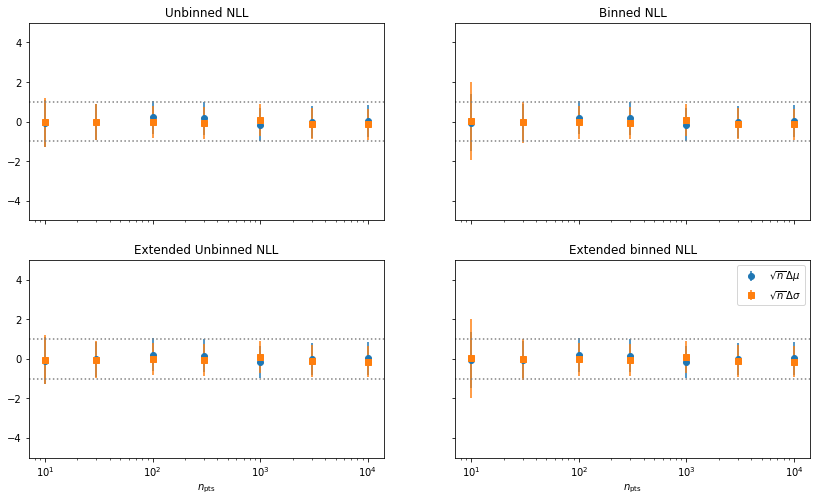

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

plt.sca(ax[0, 0])
plt.title("Unbinned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * unbinned_nll[0],
    np.sqrt(n_pts * unbinned_nll[1]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * unbinned_nll[2],
    np.sqrt(n_pts * unbinned_nll[3]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[0, 1])
plt.title("Binned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * binned_nll[0],
    np.sqrt(n_pts * binned_nll[1]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * binned_nll[2],
    np.sqrt(n_pts * binned_nll[3]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[1, 0])
plt.title("Extended Unbinned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_unbinned_nll[2],
    np.sqrt(n_pts * extended_unbinned_nll[3]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_unbinned_nll[4],
    np.sqrt(n_pts * extended_unbinned_nll[5]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[1, 1])
plt.title("Extended binned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_binned_nll[2],
    np.sqrt(n_pts * extended_binned_nll[3]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_binned_nll[4],
    np.sqrt(n_pts * extended_binned_nll[5]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.ylim(-5, 5)
plt.legend()
plt.semilogx();
for i in (0, 1):
    ax[1, i].set_xlabel(r"$n_\mathrm{pts}$")
for axi in ax.flat:
    for y in (-1, 1):
        axi.axhline(y, ls=":", color="0.5")

## Least-squares fits

We do the same as before, but this time we use a least-squares fit of $x,y$ scattered data and vary the residual function. Other functions than the identity can be used to reduce the pull of large outliers, turning the ordinary least-squares fit into a robust fit.

In [29]:
n_tries = 100  # increase this to 500 to get less scattering

truth = Namespace(a=1, b=2)

n_pts = np.array((10, 30, 100, 300, 1000, 3000, 10000))


@joblib.delayed
def compute(n):
    rng = np.random.default_rng(n)
    x = np.linspace(0, 1, n)

    linear = []
    soft_l1 = []
    arctan = []
    for i_try in range(n_tries):

        def model(x, a, b):
            return a + b * x

        while True:
            y = model(x, 1, 2)
            ye = 0.1
            y += rng.normal(0, ye, len(y))

            m = [
                Minuit(LeastSquares(x, y, ye, model), a=0, b=0),
                Minuit(LeastSquares(x, y, ye, model, loss="soft_l1"), a=0, b=0),
                Minuit(LeastSquares(x, y, ye, model, loss=np.arctan), a=0, b=0),
            ]

            all_good = True
            for mi in m:
                mi.migrad()
                mi.hesse()
                if not mi.valid or not mi.accurate:
                    all_good = False
                    break
            if all_good:
                break
            print(f"{n} {i_try} need to re-try {[(mi.valid, mi.accurate) for mi in m]}")

        linear.append(
            (
                m[0].values["a"] - truth.a,
                m[0].values["b"] - truth.b,
                m[0].errors["a"] ** 2,
                m[0].errors["b"] ** 2,
            )
        )
        soft_l1.append(
            (
                m[1].values["a"] - truth.a,
                m[1].values["b"] - truth.b,
                m[1].errors["a"] ** 2,
                m[1].errors["b"] ** 2,
            )
        )
        arctan.append(
            (
                m[2].values["a"] - truth.a,
                m[2].values["b"] - truth.b,
                m[2].errors["a"] ** 2,
                m[2].errors["b"] ** 2,
            )
        )

    return [
        (*np.mean(t, axis=0), *np.var(np.array(t)[:,:2], axis=0))
        for t in (linear, soft_l1, arctan)
    ]

linear = []
soft_l1 = []
arctan = []

for l, s, a in joblib.Parallel(-1)(compute(n) for n in n_pts):
    linear.append(l)
    soft_l1.append(s)
    arctan.append(a)

linear = np.transpose(linear)
soft_l1 = np.transpose(soft_l1)
arctan = np.transpose(arctan)

10000 17 need to re-try [(True, True), (True, True), (False, False)]
10000 69 need to re-try [(True, True), (True, True), (False, False)]


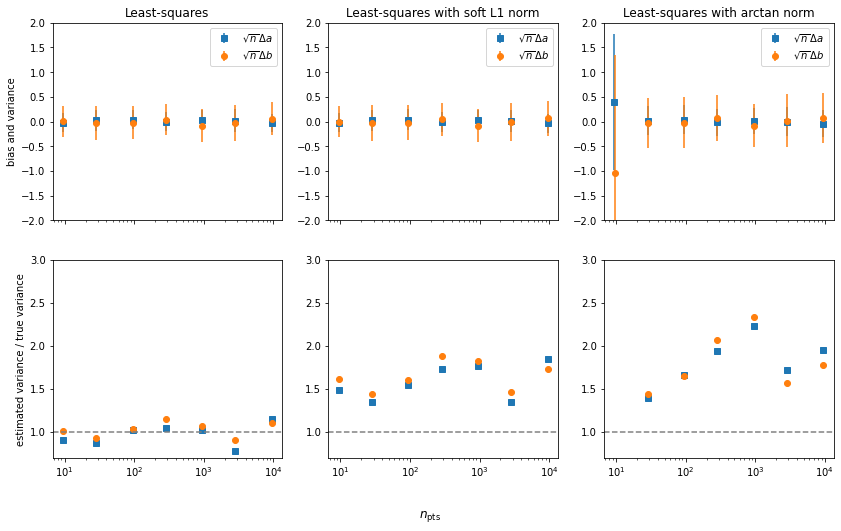

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=False)

for k, (title, func) in enumerate((
    ("Least-squares", linear),
    ("Least-squares with soft L1 norm", soft_l1),
    ("Least-squares with arctan norm", arctan),
)):
    ax[0, k].set_title(title)
    for i, x in enumerate("ab"):
        ax[0, k].errorbar(
            n_pts * 0.95 + 0.1 * i,
            np.sqrt(n_pts) * func[0 + i],
            np.sqrt(n_pts * func[4 + i]),
            fmt="so"[i],
            label=f"$\sqrt{{n}}\,\Delta {x}$",
        )
        ax[1, k].plot(
            n_pts * 0.95 + 0.1 * i,
            func[2 + i] / func[4 + i],
            "so"[i],
            label=f"$\sqrt{{n}}\,\Delta {x}$",
        )
        ax[0, k].legend()
plt.semilogx()
for i in range(3):
    ax[1, i].axhline(1, ls="--", color="0.5")
    ax[0, i].set_ylim(-2, 2)
    ax[1, i].set_ylim(0.7, 3)
ax[0, 0].set_ylabel("bias and variance")
ax[1, 0].set_ylabel("estimated variance / true variance")
fig.supxlabel(r"$n_\mathrm{pts}$");

The normal least-squares fit has a smallest variance, which is equal to the minimum variance for this problem given by the Cramer-Rao bound. The robust fits use less information to achieve robustness, hence the variance is larger. The loss from the soft L1 norm in this case is nearly negligible, but for the arctan norm it is noticable.

**Beware**: The variance estimate obtained from the fit is wrong for robust least-squares, since the robust least-squares is not even asymptotically a maximum-likelihood estimator. The estimate is significantly larger than the actual variance for the soft_l1 and arctan norms in this case.